In [1]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
import shap
import sys
import os
from datetime import timedelta
from sklearn.model_selection import learning_curve


In [2]:
print("Python version:", sys.version)
print("SHAP version:", shap.__version__)

Python version: 3.11.10 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:26) [MSC v.1929 64 bit (AMD64)]
SHAP version: 0.46.0


In [3]:

# Read the CSV data
data = pd.read_csv('F:/0 UCAM/project7_CanaryIslands/modeling/Date_fuerteventura_SPEI6.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

In [4]:

# Calculate the start date for the last 10 years
end_date = data.index[-1]
start_date = end_date - timedelta(days=365.25 * 10)

In [5]:

# Create features
def create_features(df, lags=12):
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['Average'].shift(i)
    df['rolling_mean_3'] = df['Average'].rolling(window=3).mean()
    df['rolling_std_3'] = df['Average'].rolling(window=3).std()
    df['month'] = df.index.month
    df.dropna(inplace=True)
    return df

data = create_features(data)

In [6]:

# Prepare data for modeling
X = data.drop('Average', axis=1)
y = data['Average']

In [7]:

# Sara

# Train-Test Split (time-aware)

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [8]:

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [9]:

# Define model pipelines
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42))
])

In [10]:

# Define parameter grids for random search
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

xgb_param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 0.9, 1.0]
}

In [11]:

# Perform random search
rf_random = RandomizedSearchCV(rf_pipeline, rf_param_grid, n_iter=20, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, return_train_score=True)
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, n_iter=20, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, return_train_score=True)

rf_random.fit(X_train, y_train)
xgb_random.fit(X_train, y_train)


C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metri...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'xgb__learning_rate': [0.01, 0.1, 0.3],
                                        'xgb__max_depth': [3, 5, 7],
                                        'xgb__n_estimators': [100, 200, 300],
                                        'xgb__subsample': [0.8, 0.9, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [12]:

# Best models
rf_model = rf_random.best_estimator_
xgb_model = xgb_random.best_estimator_

In [13]:
# Extract best parameters from RandomizedSearchCV
xgb_best_params = xgb_random.best_params_

# Create a standalone XGBRegressor with best parameters
xgb_best_model = XGBRegressor(**xgb_best_params, random_state=42)



In [14]:

# Predictions
rf_pred = rf_model.predict(X)
xgb_pred = xgb_model.predict(X)

In [15]:

# Combine actual and predicted values into a DataFrame
comparison_df = pd.DataFrame({
    'Date': data.index,
    'Actual SPEI6': y,
    'Random Forest Prediction': rf_pred,
    'XGBoost Prediction': xgb_pred
})

# Save to Excel
comparison_df.to_csv('F:/0 UCAM/project7_CanaryIslands/modeling/spei6_actual_vs_predictions_full_fuerteventura.csv', index=False)


In [16]:

# Evaluation
results = {}
for name, model in [("Random Forest", rf_random), ("XGBoost", xgb_random)]:
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    results[name] = {
        'MSE': mse, 
        'R2': r2,
        'Best Parameters': model.best_params_ 
    }

In [17]:

# Print model performance for the whole data set
print("Model Performance for the whole data:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")
    print(f"  Best Parameters: {metrics['Best Parameters']}")

Model Performance for the whole data:
Random Forest:
  MSE: 0.0289
  R2: 0.9714
  Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 30}
XGBoost:
  MSE: 0.0087
  R2: 0.9914
  Best Parameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1}


In [18]:
def nse(obs, sim):
    return 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)

def pbias(obs, sim):
    return 100 * np.sum(sim - obs) / np.sum(obs)

def kge(obs, sim):
    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)


resultsTrain = {}
for name, model in [("Random Forest", rf_random), ("XGBoost", xgb_random)]:
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    nse_train = nse(y_train, y_pred_train)
    pbias_train = pbias(y_train, y_pred_train)
    kge_train = kge(y_train, y_pred_train)
    resultsTrain[name] = {
        'Train MSE': mse_train,
        'Train R2': r2_train,
        'Train NSE': nse_train,
        'Train PBIAS': pbias_train,
        'Train KGE': kge_train,
        'Best Parameters': model.best_params_
    }

# Print model performance for the training data set
print("Model Performance for the training data set:")
for name, metrics in resultsTrain.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['Train MSE']:.4f}")
    print(f"  R2: {metrics['Train R2']:.4f}")
    print(f"  NSE: {metrics['Train NSE']:.4f}")
    print(f"  PBIAS: {metrics['Train PBIAS']:.4f}")
    print(f"  KGE: {metrics['Train KGE']:4f}")
    print(f"  Best Parameters: {metrics['Best Parameters']}")

Model Performance for the training data set:
Random Forest:
  MSE: 0.0204
  R2: 0.9784
  NSE: 0.9784
  PBIAS: -164.3356
  KGE: -0.643869
  Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 30}
XGBoost:
  MSE: 0.0020
  R2: 0.9979
  NSE: 0.9979
  PBIAS: -16.7909
  KGE: 0.831902
  Best Parameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1}


In [19]:

resultsTest = {}
for name, model in [("Random Forest", rf_random), ("XGBoost", xgb_random)]:
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    nse_test = nse(y_test, y_pred_test)
    pbias_test = pbias(y_test, y_pred_test)
    kge_test = kge(y_test, y_pred_test)
    resultsTest[name] = {
        'Test MSE': mse_test,
        'Test R2': r2_test,
        'Test NSE': nse_test,
        'Test PBIAS': pbias_test,
        'Test KGE': kge_test,
        'Best Parameters': model.best_params_
    }

# Print model performance for the training data set
print("Model Performance for the test data set:")
for name, metrics in resultsTest.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['Test MSE']:.4f}")
    print(f"  R2: {metrics['Test R2']:.4f}")
    print(f"  NSE: {metrics['Test NSE']:.4f}")
    print(f"  PBIAS: {metrics['Test PBIAS']:.4f}")
    print(f"  KGE: {metrics['Test KGE']:4f}")
    print(f"  Best Parameters: {metrics['Best Parameters']}")

Model Performance for the test data set:
Random Forest:
  MSE: 0.0628
  R2: 0.9274
  NSE: 0.9274
  PBIAS: -4.2146
  KGE: 0.916539
  Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 30}
XGBoost:
  MSE: 0.0357
  R2: 0.9588
  NSE: 0.9588
  PBIAS: 0.4667
  KGE: 0.968016
  Best Parameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1}


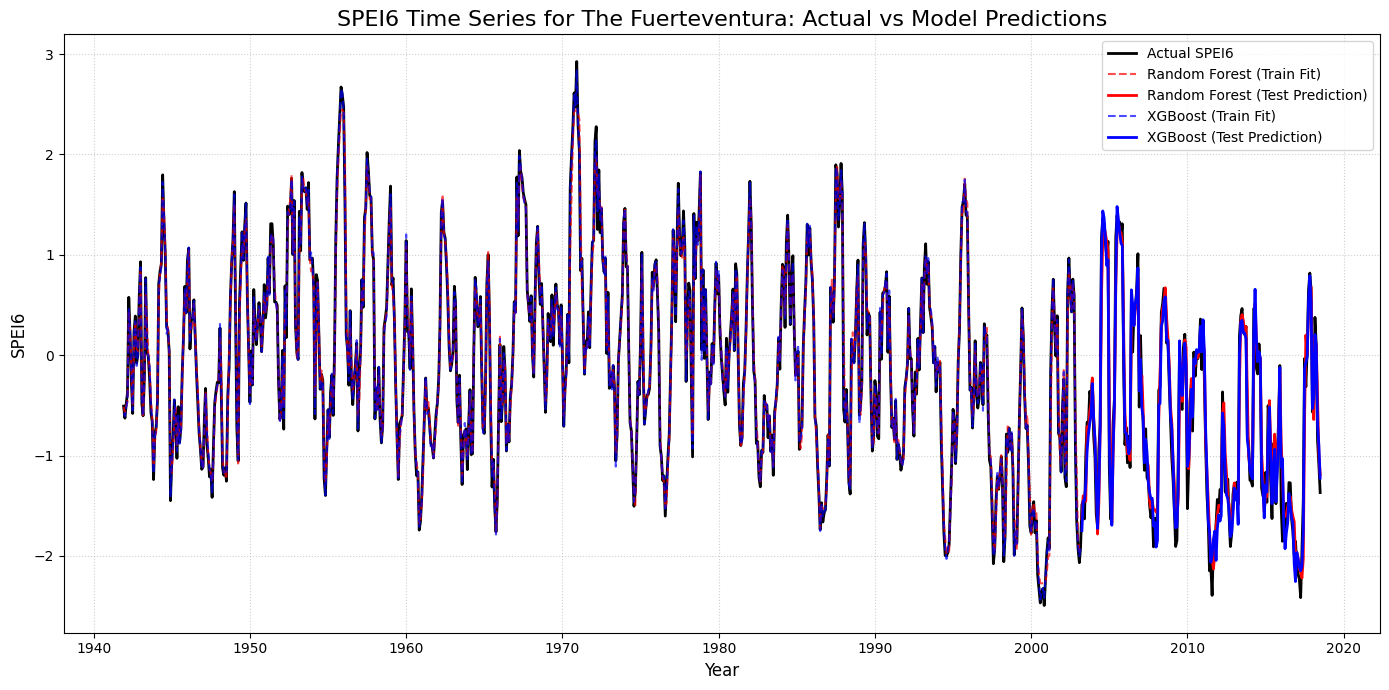

In [20]:

# Sara
# 5. Plotting Actual vs Predictions

plt.figure(figsize=(14, 7))
plt.plot(data.index, y, label="Actual SPEI6", color="black", linewidth=2)

# Predictions on train and test sets
for name, model, color in [
    ("Random Forest", rf_model, "red"),
    ("XGBoost", xgb_model, "blue")
]:
    # Training predictions
    train_pred = model.predict(X_train)
    plt.plot(X_train.index, train_pred, 
             label=f"{name} (Train Fit)", 
             linestyle="--", alpha=0.7, color=color)
    
    # Test predictions
    test_pred = model.predict(X_test)
    plt.plot(X_test.index, test_pred, 
             label=f"{name} (Test Prediction)", 
             linestyle="-", linewidth=2, color=color)

plt.title("SPEI6 Time Series for The Fuerteventura: Actual vs Model Predictions", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("SPEI6", fontsize=12)
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.savefig('F:/0 UCAM/project7_CanaryIslands/modeling/spei6_train_test_predictions_fuerteventura.png', dpi=300)
plt.show()


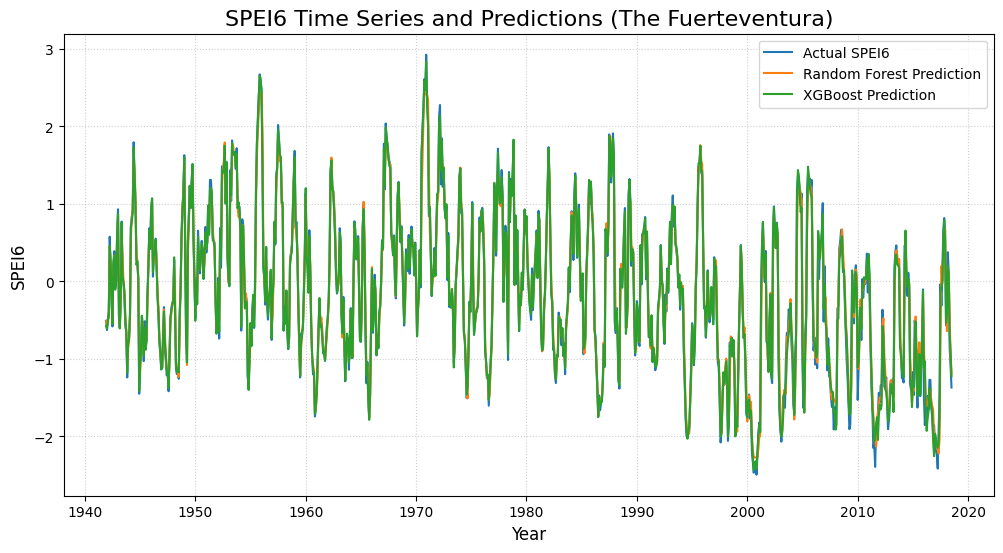

In [21]:

# Plotting predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, y, label='Actual SPEI6')
plt.plot(data.index, rf_pred, label='Random Forest Prediction')
plt.plot(data.index, xgb_pred, label='XGBoost Prediction')
plt.title('SPEI6 Time Series and Predictions (The Fuerteventura)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('SPEI6', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig('F:/0 UCAM/project7_CanaryIslands/modeling/spei6_predictions_fuerteventura.png', dpi=300)
plt.show()

In [22]:
def find_extrema_in_range(series, n_abs=2):
    diff = series.diff()
    max_candidates = series[(diff.shift(-1) < 0) & (diff > 0)]
    min_candidates = series[(diff.shift(-1) > 0) & (diff < 0)]

    # Real max: highest positive local maximum
    real_max = max_candidates[max_candidates > 0].idxmax() if not max_candidates[max_candidates > 0].empty else None

    # Real min: lowest negative local minimum
    real_min = min_candidates[min_candidates < 0].idxmin() if not min_candidates[min_candidates < 0].empty else None

    # Top n extrema by absolute value
    max_abs_indices = sorted(max_candidates.index, key=lambda x: abs(series.loc[x]), reverse=True)[:n_abs]
    min_abs_indices = sorted(min_candidates.index, key=lambda x: abs(series.loc[x]), reverse=True)[:n_abs]

    return {
        "real_max": real_max,
        "real_min": real_min,
        "top_max_abs": max_abs_indices,
        "top_min_abs": min_abs_indices
    }


In [23]:
# Filter the data for the last 10 years
data_last_10_years = data[data.index >= start_date]

# Find extrema using the revised function
extrema = find_extrema_in_range(data_last_10_years['Average'], n_abs=2)

# Assign results to familiar variable names
max_indices = [extrema['real_max']] + extrema['top_max_abs']
min_indices = [extrema['real_min']] + extrema['top_min_abs']


In [24]:

# Combine maxima and minima indices
extrema_indices = sorted(list(max_indices) + list(min_indices))

In [25]:

mid_candidates = []
series = data_last_10_years['Average']
values = series.values
index = series.index

i = 0
while i < len(values) - 2:
    # Strictly increasing segment
    if values[i] < values[i + 1]:
        start = i
        while i < len(values) - 1 and values[i] < values[i + 1]:
            i += 1
        end = i

        if end > start + 1:
            start_val = values[start]
            end_val = values[end]
            mid_val = (start_val + end_val) / 2

            segment = values[start + 1:end]
            segment_idx = index[start + 1:end]
            diffs = np.abs(segment - mid_val)
            best_j = np.argmin(diffs)
            mid_index = segment_idx[best_j]
            diff = abs(end_val - start_val)
            mid_candidates.append((mid_index, diff))

    # Strictly decreasing segment
    elif values[i] > values[i + 1]:
        start = i
        while i < len(values) - 1 and values[i] > values[i + 1]:
            i += 1
        end = i

        if end > start + 1:
            start_val = values[start]
            end_val = values[end]
            mid_val = (start_val + end_val) / 2

            segment = values[start + 1:end]
            segment_idx = index[start + 1:end]
            diffs = np.abs(segment - mid_val)
            best_j = np.argmin(diffs)
            mid_index = segment_idx[best_j]
            diff = abs(start_val - end_val)
            mid_candidates.append((mid_index, diff))
    else:
        i += 1

# Filter to last 10 years
mid_candidates = [(idx, diff) for idx, diff in mid_candidates if idx >= start_date]

# Select top 3 by vertical difference
mid_candidates_sorted = sorted(mid_candidates, key=lambda x: x[1], reverse=True)[:3]
mid_indices = [idx for idx, _ in mid_candidates_sorted]


In [26]:
# Combine extrema and midpoints for explanation
all_explanation_indices = sorted(extrema_indices + mid_indices)


In [27]:

# Function to create SHAP force plot
def create_shap_force_plot(shap_values, instance, feature_names, model_name, date):
    plt.figure(figsize=(1.2, 1.2))

    # Increase font sizes globally
    plt.rcParams.update({'font.size': 6})
    
    # Sort features by absolute SHAP value
    feature_order = np.argsort(np.abs(shap_values[0]))
    
    # Get top 10 features
    top_features = feature_order[-10:]
    
    # Create the plot
    plt.barh(range(len(top_features)), shap_values[0][top_features], color=['red' if x > 0 else 'blue' for x in shap_values[0][top_features]], edgecolor='black', linewidth=1.2)
    plt.yticks(range(len(top_features)), [f"{feature_names[i]} = {instance.iloc[0,i]:.2f}" for i in top_features], fontsize=6)
    plt.xlabel('SHAP value', fontsize=6, fontweight='bold')
    plt.title(f'{date}', fontsize=6, fontweight='bold')
    
    # Add SHAP values as text
    #for i, v in enumerate(shap_values[0][top_features]):
    #    plt.text(v, i, f'{v:.2f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"F:/0 UCAM/project7_CanaryIslands/modeling/shap_force_plot_{model_name}_{date}_fuerteventura.png", dpi=600, bbox_inches='tight')
    plt.show()

In [28]:

# SHAP Explanations
explainer_rf = shap.TreeExplainer(rf_model.named_steps['rf'])
explainer_xgb = shap.TreeExplainer(xgb_model.named_steps['xgb'])

In [29]:

# LIME Explainer
lime_explainer = LimeTabularExplainer(X.values, feature_names=X.columns, mode='regression')

Generating explanations for 2009-01-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


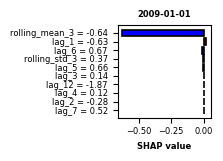

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


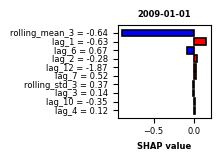

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating explanations for 2011-03-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


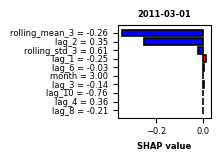

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


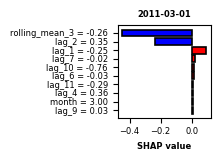

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Generating explanations for 2011-07-01 00:00:00


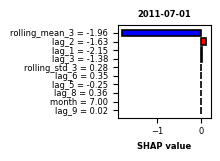

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


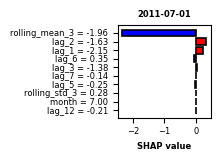

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating explanations for 2011-08-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


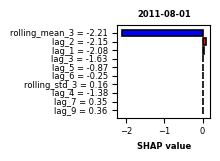

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


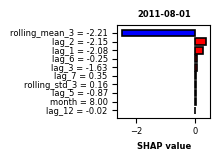

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Generating explanations for 2011-09-01 00:00:00


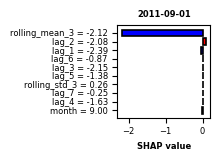

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


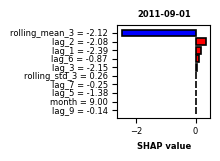

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating explanations for 2017-04-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


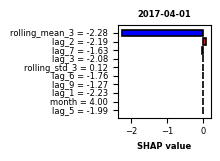

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


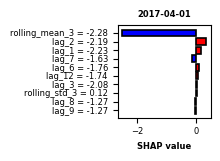

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating explanations for 2017-04-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


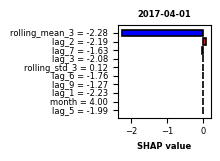

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


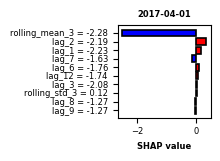

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating explanations for 2017-06-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


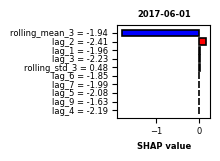

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


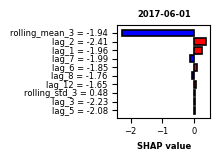

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating explanations for 2017-11-01 00:00:00


C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


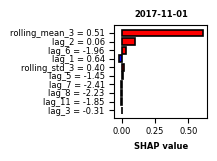

C:\Users\Sara\AppData\Local\Temp\ipykernel_18976\3914910914.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


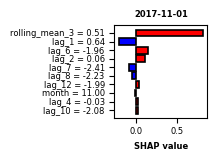

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [30]:

# Generate explanations for each extrema
for idx in all_explanation_indices:
    print(f"Generating explanations for {idx}")
    instance = X.loc[idx:idx]  # Get a single row as a DataFrame
    
    # SHAP explanations
    shap_values_rf = explainer_rf.shap_values(instance)
    shap_values_xgb = explainer_xgb.shap_values(instance)
    
    # Create SHAP force plots
    create_shap_force_plot(shap_values_rf, instance, X.columns, "Random Forest", idx.date())
    create_shap_force_plot(shap_values_xgb, instance, X.columns, "XGBoost", idx.date())
    
    # LIME explanations
    lime_exp_rf = lime_explainer.explain_instance(instance.values[0], rf_model.predict, num_features=10)
    lime_exp_xgb = lime_explainer.explain_instance(instance.values[0], xgb_model.predict, num_features=10)
    
    # Save LIME explanations as HTML
    lime_exp_rf.save_to_file(f"F:/0 UCAM/project7_CanaryIslands/modeling/lime_explanation_rf_fuerteventura_{idx.date()}.html")
    lime_exp_xgb.save_to_file(f"F:/0 UCAM/project7_CanaryIslands/modeling/lime_explanation_xgb_fuerteventura_{idx.date()}.html")

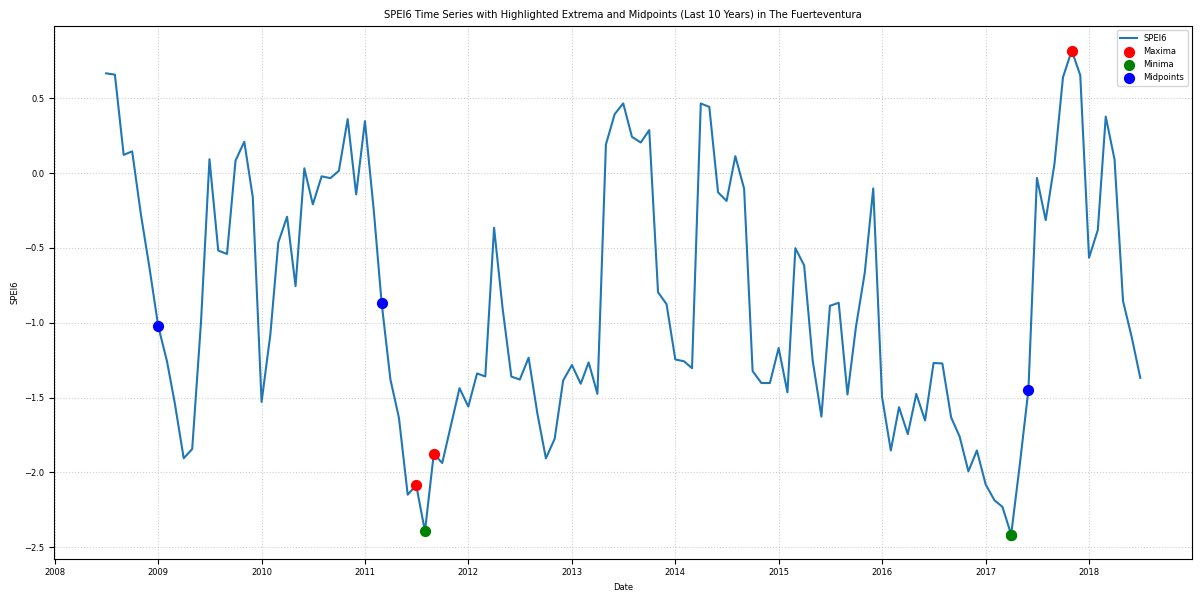

Analysis complete. Check the 'output' directory for generated files and visualizations.


In [31]:

# Plot the time series with highlighted extrema for the last 10 years
plt.figure(figsize=(12, 6))
plt.plot(data_last_10_years.index, data_last_10_years['Average'], label='SPEI6')
plt.scatter(max_indices, data_last_10_years.loc[max_indices, 'Average'], color='red', label='Maxima', zorder=5, s=50)
plt.scatter(min_indices, data_last_10_years.loc[min_indices, 'Average'], color='green', label='Minima', zorder=5, s=50)
plt.scatter(mid_indices, data_last_10_years.loc[mid_indices, 'Average'], color='blue', label='Midpoints', zorder=5, s=50)
plt.title('SPEI6 Time Series with Highlighted Extrema and Midpoints (Last 10 Years) in The Fuerteventura')
plt.xlabel('Date')
plt.ylabel('SPEI6')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('F:/0 UCAM/project7_CanaryIslands/modeling/time_series_with_extrema_last_10_years_fuerteventura.png', dpi=300)
plt.show()

print("Analysis complete. Check the 'output' directory for generated files and visualizations.")
